<h1>Thêm thư viện cần thiết

In [195]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.utils import column_or_1d

import pandas as pd
import warnings
import io
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

warnings.filterwarnings('ignore')


<h1>Nạp dữ liệu

In [196]:
from google.colab import files


uploaded = files.upload()

Saving Bitcoin Data.csv to Bitcoin Data (2).csv


In [197]:
data = pd.read_csv(io.BytesIO(uploaded['Bitcoin Data.csv']))

# Chuyển cột 'Date' sang kiểu dữ liệu ngày tháng
data['Date'] = pd.to_datetime(data['Date'])
data721 = data
data622 = data
data811 = data

In [198]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = data721[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

df_index = df.index

# Tạo mới cột Timestamp để dự báo theo chuỗi thời gian

In [199]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df.head()

,Close,Timestamp
0,36687.6,0.000000e+00
1,37555.8,1.000000e-09
2,39187.3,2.000000e-09
3,36851.3,3.000000e-09
4,35520.0,4.000000e-09


# Vẽ đồ thị

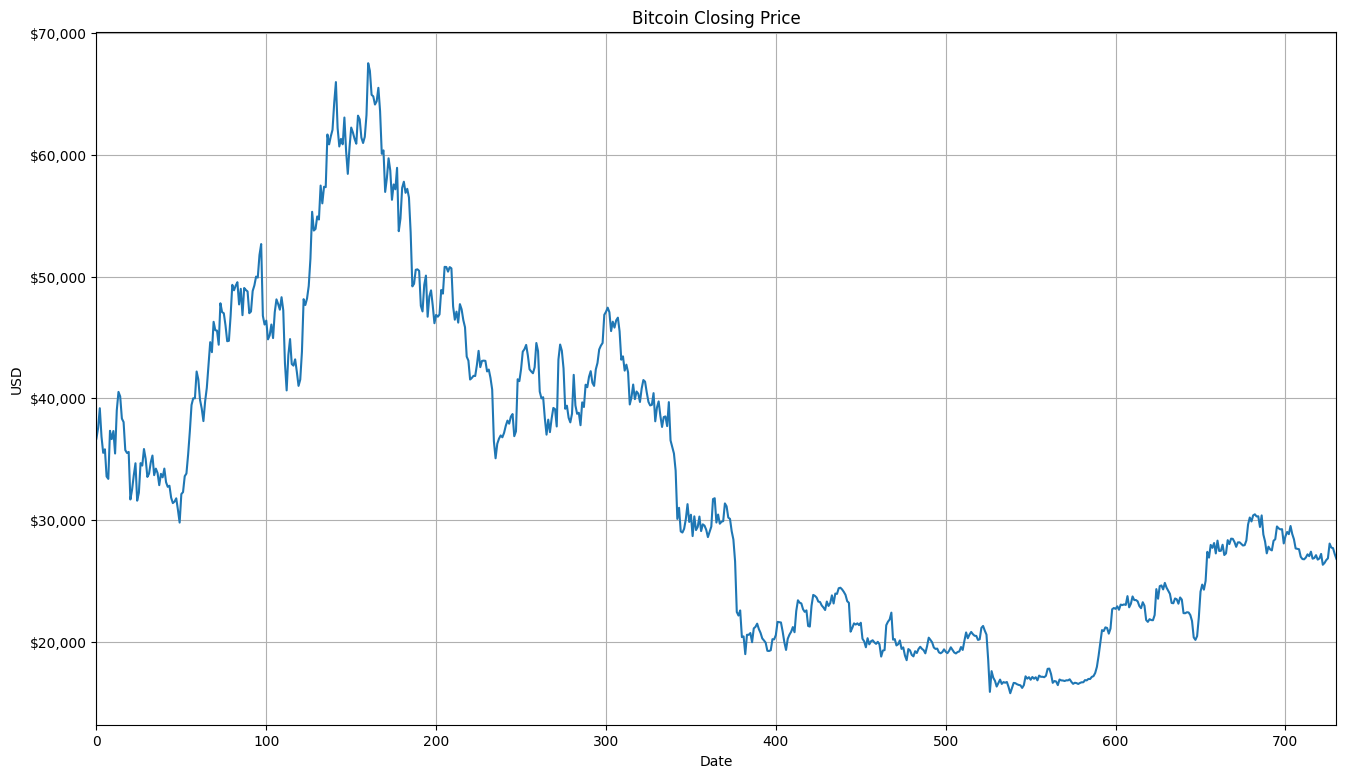

In [200]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Closing Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)


# Thực hiện xây dựng mô hình SVR

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [201]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['Close'] = y_scaled
df_scaled.head()

,Timestamp,Close
0,-1.729683,0.281676
1,-1.724944,0.349129
2,-1.720205,0.475886
3,-1.715466,0.294394
4,-1.710728,0.190961


## Chia dữ liệu thành tập train và tập test

In [202]:
interrupt = int(len(df_scaled) * .7)
interrupt

511

In [203]:
train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)


(511, 2)
(220, 2)


In [204]:
# Split the data into training, testing, and validation sets


train_size = int(0.7 * len(data721))
test_size = int(0.2 * len(data721))
val_size = len(data721) - train_size - test_size

atrain_data = data721[:train_size]
atest_data = data721[train_size:train_size+test_size]
aval_data = data721[train_size+test_size:]

data721 = df_scaled

train_data = data721[:train_size]
test_data = data721[train_size:train_size+test_size]
val_data = data721[train_size+test_size:]

index_test = df_scaled.index[interrupt:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)



(511, 2)
(146, 2)
(74, 2)


In [205]:
train_data.tail()

,Timestamp,Close
506,0.668179,-1.089199
507,0.672918,-1.079899
508,0.677657,-1.076620
509,0.682395,-1.048153
510,0.687134,-1.066776


In [206]:
test_data.head()

,Timestamp,Close
511,0.691873,-1.008413
512,0.696612,-0.955053
513,0.701351,-0.992082
514,0.706090,-0.968657
515,0.710829,-0.951922


In [207]:
val_data.head()

,Timestamp,Close
657,1.383746,-0.415008
658,1.388485,-0.384435
659,1.393224,-0.450653
660,1.397963,-0.369153
661,1.402702,-0.435076


# Vẽ đồ thị thể hiện tập train và tập test

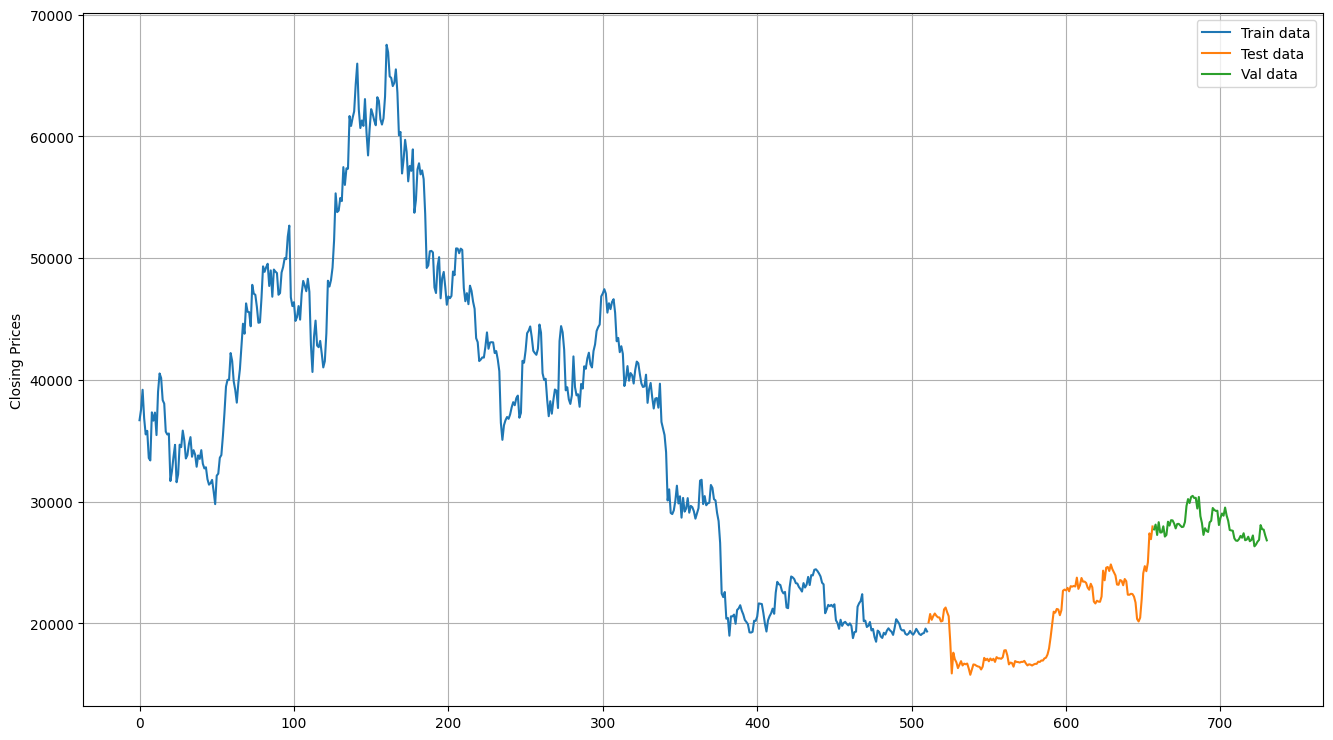

In [208]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(atrain_data['Close'], label='Train data')
plt.plot(atest_data['Close'], label='Test data')
plt.plot(aval_data['Close'], label='Val data')
plt.legend()


# Xác định biến độc lập (X) và biến phụ thuộc (y)

In [209]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['Close'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['Close'].values.reshape(-1, 1)

X_val = val_data['Timestamp'].values.reshape(-1, 1)
y_val = val_data['Close'].values.reshape(-1, 1)


## Hàm tạo hyperparameters

In [210]:
def para_range(minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list


# Hàm xuất kết quả của từng trường hợp trong GridSearch

In [211]:
def print_stats(hyperparams, stats):
    if(hyperparams[0] == 'poly'):
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')
    else:
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}')

    print(
        f"MAE={stats[0]:.2f} | MAPE={stats[1]:.2f} | MSE={stats[2] :.2f} | RMSE={stats[3]:.2f}")


# Tạo các giá trị cho các hyperparameters

In [212]:
kernels = ['sigmoid', 'rbf', 'poly']
Cs = para_range(0.01, 0.2, 0.1)
gammas = para_range(0.1, 5, 0.1)
degrees = para_range(1, 6, 1)


## GridSearch để tìm hyperparameters phù hợp

In [213]:
warnings.filterwarnings('ignore')

stats_df = pd.DataFrame(
    columns=['kernel', 'C', 'gamma', 'degree', 'MAE', 'MAPE', 'MSE', 'RMSE'])

# Sử dụng gird-seach để tìm hyperparameters phù hợp
for ker in kernels:
    # Nếu kernel == poly thì thực hiện chọn degree
    if(ker != 'poly'):
        for C in Cs:
            for gamma in gammas:
                rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                rgs.fit(X_train, y_train)
                pred = rgs.predict(X_test)

                # Đảo tỷ lệ thành giá trị thực
                inv_pred = y_sc.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
                inv_test = y_sc.inverse_transform(
                    column_or_1d(y_test).reshape(-1, 1))

                # Đánh giá mô hình
                mae = mean_absolute_error(inv_test, inv_pred)
                mape = mean_absolute_percentage_error(inv_test, inv_pred)
                mse = mean_squared_error(inv_test, inv_pred)
                rmse = np.sqrt(mse)

                result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                          'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                hyperparam = [ker, C, gamma, 0]
                stats = [mae, mape, mse, rmse]
                stats_df = stats_df.append(result, ignore_index=True)
                print_stats(hyperparam, stats)
    else:
        for C in Cs:
            for gamma in gammas:
                for deg in degrees:
                    rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                    rgs.fit(X_train, y_train.reshape(-1, 1))
                    pred = rgs.predict(X_test)

                    # Đảo tỷ lệ thành giá trị thực
                    inv_pred = y_sc.inverse_transform(
                        column_or_1d(pred).reshape(-1, 1))
                    inv_test = y_sc.inverse_transform(
                        column_or_1d(y_test).reshape(-1, 1))

                    # Đánh giá mô hình
                    mae = mean_absolute_error(inv_test, inv_pred)
                    mape = mean_absolute_percentage_error(inv_test, inv_pred)
                    mse = mean_squared_error(inv_test, inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                            'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                    hyperparam = [ker, C, gamma, 0]
                    stats = [mae, mape, mse, rmse]

                    stats_df = stats_df.append(result, ignore_index=True)

                    print_stats(hyperparam, stats)


SVR(kernel=sigmoid, C=0.01, gamma=0.1
MAE=15348.33 | MAPE=0.81 | MSE=247144243.96 | RMSE=15720.82
SVR(kernel=sigmoid, C=0.01, gamma=0.2
MAE=12525.35 | MAPE=0.67 | MSE=170274703.48 | RMSE=13048.93
SVR(kernel=sigmoid, C=0.01, gamma=0.30000000000000004
MAE=10053.31 | MAPE=0.54 | MSE=116463245.00 | RMSE=10791.81
SVR(kernel=sigmoid, C=0.01, gamma=0.4
MAE=7333.74 | MAPE=0.41 | MSE=69803523.97 | RMSE=8354.85
SVR(kernel=sigmoid, C=0.01, gamma=0.5
MAE=5510.98 | MAPE=0.31 | MSE=44804519.73 | RMSE=6693.62
SVR(kernel=sigmoid, C=0.01, gamma=0.6
MAE=4728.91 | MAPE=0.26 | MSE=29663367.65 | RMSE=5446.41
SVR(kernel=sigmoid, C=0.01, gamma=0.7000000000000001
MAE=4597.38 | MAPE=0.24 | MSE=24343749.24 | RMSE=4933.94
SVR(kernel=sigmoid, C=0.01, gamma=0.8
MAE=4602.10 | MAPE=0.23 | MSE=24665635.23 | RMSE=4966.45
SVR(kernel=sigmoid, C=0.01, gamma=0.9
MAE=4600.94 | MAPE=0.22 | MSE=28627628.34 | RMSE=5350.48
SVR(kernel=sigmoid, C=0.01, gamma=1.0
MAE=4639.96 | MAPE=0.22 | MSE=33289617.86 | RMSE=5769.72
SVR(kernel

In [214]:
best_fit_model = stats_df[stats_df['MAPE']
                          == stats_df['MAPE'].min()].head(1)
best_fit_model


,kernel,C,gamma,degree,MAE,MAPE,MSE,RMSE
152,rbf,0.11,0.6,0,2142.692526,0.108418,5.347781e+06,2312.527077


In [229]:
kernel = str(best_fit_model['kernel'].values[0])
C = float(best_fit_model['C'])
gamma = float(best_fit_model['gamma'])
degree = int(best_fit_model['degree'])

if(kernel == 'poly'):
    rgs = SVR(kernel=kernel, C=C, gamma=gamma, degree=degree)
else:
    rgs = SVR(kernel=kernel, C=C, gamma=gamma)

rgs.fit(X_train, y_train)
pred = rgs.predict(X_test)
val_pred = rgs.predict(X_val)
pred

array([-1.10678766, -1.10787916, -1.1089112 , -1.10988413, -1.11079824,
       -1.11165389, -1.11245138, -1.11319107, -1.11387328, -1.11449836,
       -1.11506667, -1.11557854, -1.11603433, -1.1164344 , -1.11677911,
       -1.11706883, -1.11730392, -1.11748475, -1.1176117 , -1.11768515,
       -1.11770547, -1.11767305, -1.11758828, -1.11745153, -1.11726322,
       -1.11702372, -1.11673345, -1.11639279, -1.11600215, -1.11556193,
       -1.11507255, -1.1145344 , -1.11394791, -1.11331348, -1.11263154,
       -1.11190249, -1.11112676, -1.11030478, -1.10943695, -1.10852372,
       -1.1075655 , -1.10656272, -1.10551581, -1.10442521, -1.10329135,
       -1.10211465, -1.10089557, -1.09963452, -1.09833195, -1.09698831,
       -1.09560401, -1.09417952, -1.09271527, -1.09121169, -1.08966924,
       -1.08808836, -1.08646949, -1.08481307, -1.08311956, -1.08138939,
       -1.07962301, -1.07782088, -1.07598343, -1.0741111 , -1.07220436,
       -1.07026364, -1.0682894 , -1.06628207, -1.06424211, -1.06

<h1>Đưa dữ liệu về miền giá trị ban đầu

In [232]:
inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))

inv_val_pred = y_sc.inverse_transform(val_pred.reshape(-1, 1))
inv_val = y_sc.inverse_transform(y_val.reshape(-1, 1))
print(inv_pred)

[[18816.50803576]
 [18802.4592822 ]
 [18789.17565684]
 [18776.6530577 ]
 [18764.88732879]
 [18753.874261  ]
 [18743.60959302]
 [18734.08901225]
 [18725.30815574]
 [18717.26261105]
 [18709.94791725]
 [18703.35956578]
 [18697.49300138]
 [18692.34362303]
 [18687.90678485]
 [18684.17779704]
 [18681.15192679]
 [18678.8243992 ]
 [18677.19039819]
 [18676.24506747]
 [18675.98351139]
 [18676.40079591]
 [18677.49194949]
 [18679.25196404]
 [18681.67579579]
 [18684.75836624]
 [18688.49456307]
 [18692.87924103]
 [18697.90722287]
 [18703.57330024]
 [18709.87223461]
 [18716.79875814]
 [18724.34757462]
 [18732.51336033]
 [18741.29076499]
 [18750.67441259]
 [18760.65890232]
 [18771.23880947]
 [18782.40868626]
 [18794.16306278]
 [18806.49644783]
 [18819.40332982]
 [18832.87817762]
 [18846.91544144]
 [18861.50955368]
 [18876.6549298 ]
 [18892.34596918]
 [18908.57705597]
 [18925.34255992]
 [18942.63683723]
 [18960.4542314 ]
 [18978.78907405]
 [18997.63568576]
 [19016.98837686]
 [19036.84144832]
 [19057.18

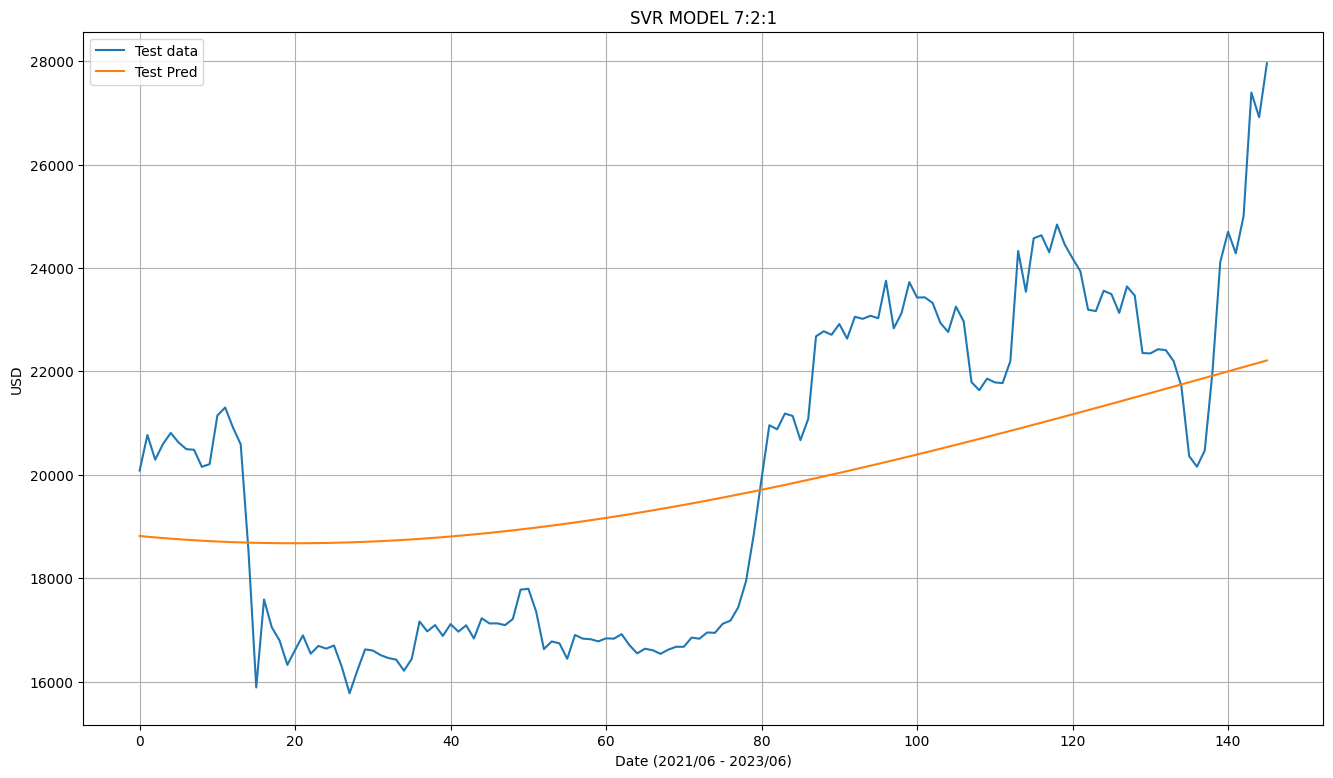

In [244]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
# Đặt tiêu đề và nhãn trục
plt.title('SVR MODEL 7:2:1')
plt.ylabel('USD')
plt.xlabel('Date (2021/06 - 2023/06)')
#plt.plot(index_train ,atrain_data['Close'], label='Train data')
#plt.plot(index_test ,atest_data['Close'], label='Test data')
#plt.plot(index_val ,aval_data['Close'], label='Val data')
plt.plot(column_or_1d(inv_test), label='Test data')
plt.plot(column_or_1d(inv_pred), label='Test Pred')
plt.legend()


In [242]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 2142.69
MAPE: 10.84%
MSE: 5347781.48
RMSE: 2312.53


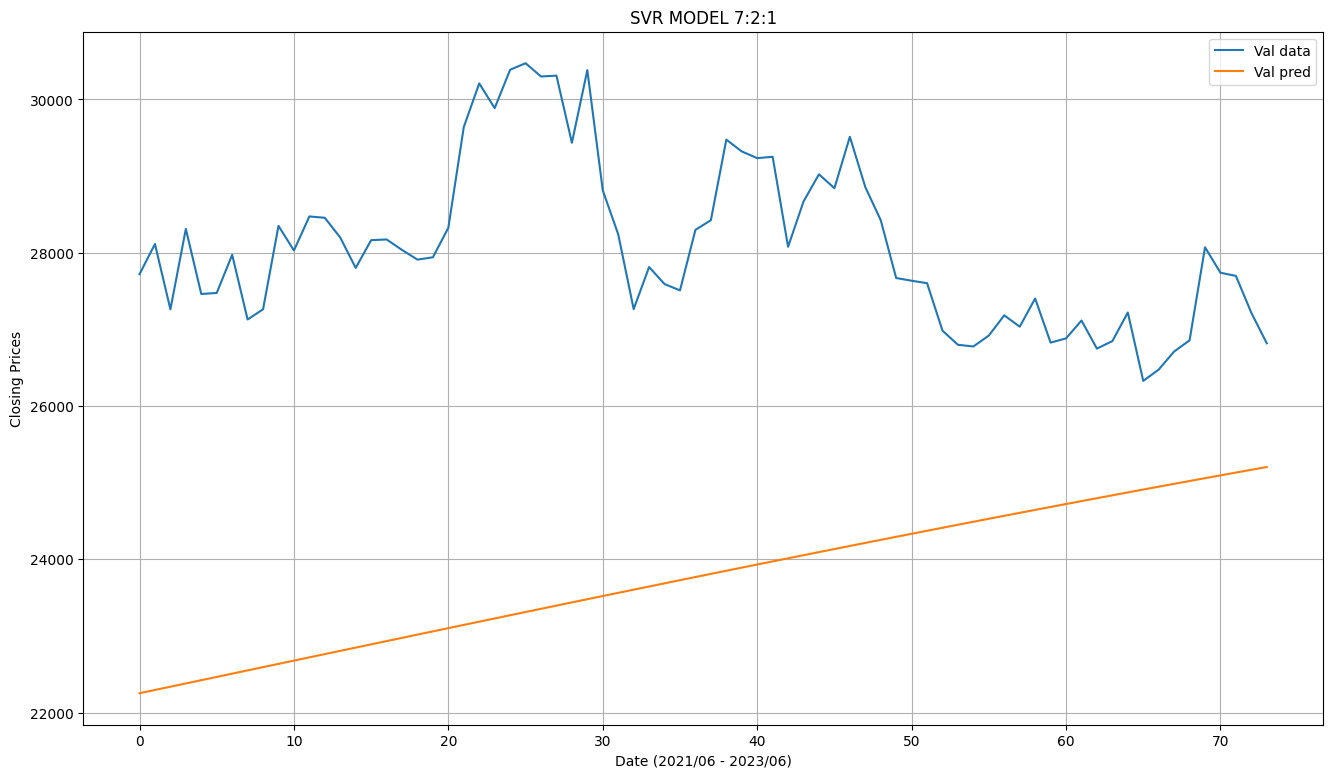

In [246]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.title('SVR MODEL 7:2:1')
plt.ylabel('USD')
plt.xlabel('Date (2021/06 - 2023/06)')
plt.ylabel('Closing Prices')
#plt.plot(index_train ,atrain_data['Close'], label='Train data')
#plt.plot(index_test ,atest_data['Close'], label='Test data')
#plt.plot(index_val ,aval_data['Close'], label='Val data')
plt.plot(column_or_1d(inv_val), label='Val data')
plt.plot(column_or_1d(inv_val_pred), label='Val pred')
plt.legend()

In [243]:
mae = mean_absolute_error(inv_val, inv_val_pred)
mape = mean_absolute_percentage_error(inv_val, inv_val_pred)
mse = mean_squared_error(inv_val, inv_val_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 4309.46
MAPE: 15.18%
MSE: 21147284.53
RMSE: 4598.62


In [236]:
#column_or_1d(inv_pred)
import numpy as np
import pandas as pd

my_array = np.array([[11,22,33],[44,55,66]])

test_pred = pd.DataFrame(inv_pred, columns = ['Close'])
val_pred = pd.DataFrame(inv_val_pred, columns = ['Close'])

print(test_pred)
print(type(test_pred))


            Close
0    18816.508036
1    18802.459282
2    18789.175657
3    18776.653058
4    18764.887329
..            ...
141  22042.040175
142  22084.388788
143  22126.774637
144  22169.193704
145  22211.642009

[146 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


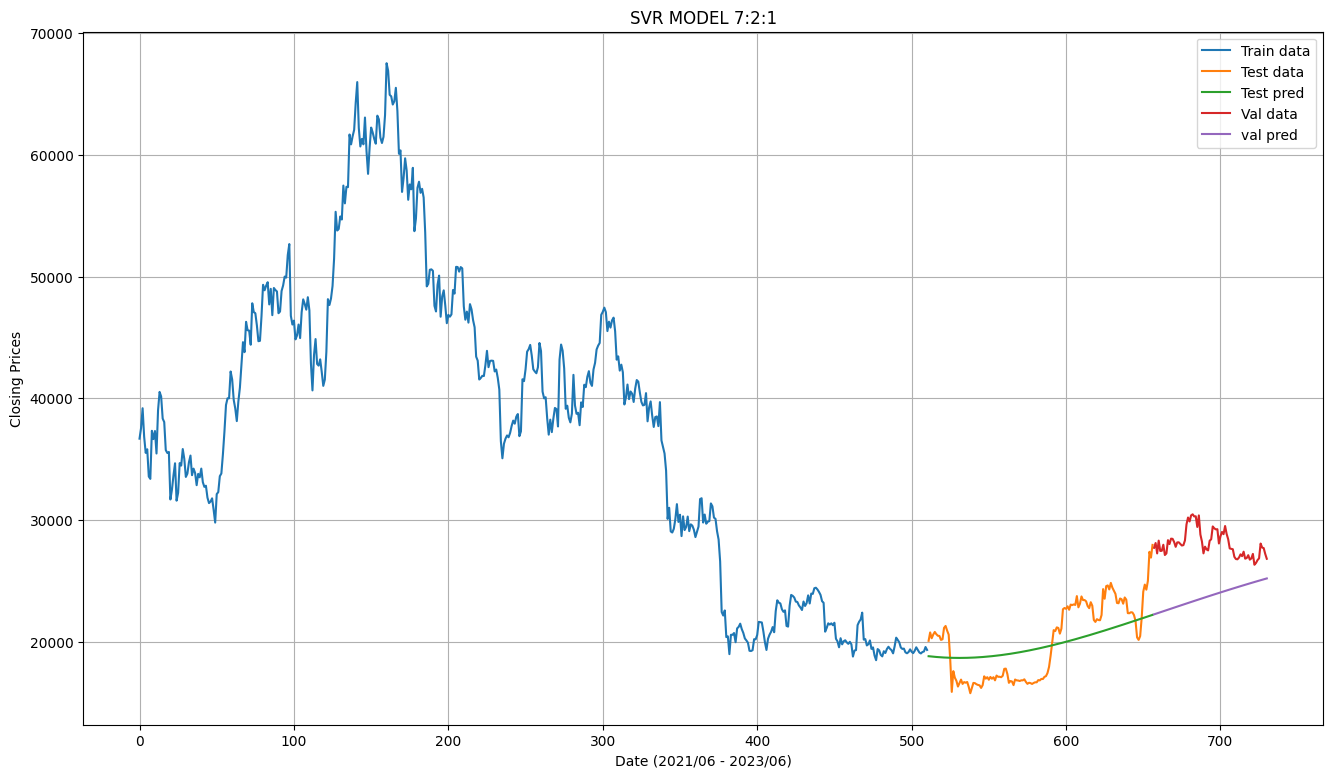

In [240]:
plt.figure(figsize=(16, 9))
plt.grid(True)

# Đặt tiêu đề và nhãn trục
plt.title('SVR MODEL 7:2:1')
plt.ylabel('USD')
plt.xlabel('Date (2021/06 - 2023/06)')

plt.ylabel('Closing Prices')
plt.plot(atrain_data['Close'], label='Train data')
plt.plot(atest_data['Close'], label='Test data')
plt.plot(test_pred.index+511 ,test_pred, label='Test pred')
plt.plot(aval_data['Close'], label='Val data')
plt.plot(val_pred.index+511+146 ,val_pred, label='val pred')

plt.legend()

# Đánh giá mô hình

In [220]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 2142.69
MAPE: 10.84%
MSE: 5347781.48
RMSE: 2312.53
